In [2]:
## data
import pandas as pd
import numpy as np
import datetime as dt
from dateutil.relativedelta import relativedelta
from unicodedata import normalize

## vis
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# contagem de aging
from collections import Counter

from IPython.display import display, HTML

## modelo
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# check xgboost version
from xgboost import XGBClassifier

## alertas
import warnings
warnings.filterwarnings("ignore")

***
### Funções

In [3]:
def just_check_nan(df):
    # Check NaN Pandas and Numpy
    missing_val_count_by_column = (df.isna().sum())

    columns_with_nan = missing_val_count_by_column[missing_val_count_by_column > 0]
    print('Dados com NaN:')
    print(columns_with_nan)
    print('')
    print('columns_with_nan.shape', columns_with_nan.shape)
    print('')

In [4]:
def plot_feature_freq(df, feature):
    labels, counts = np.unique(df[feature].dropna(), return_counts=True)
    total = counts[0] + counts[1]
    plt.figure(figsize=(10, 7))
    ax = sns.barplot(x=labels, y=(counts/total)*100, data = df)
    ax2 = sns.barplot(x=labels, y=counts, data = df)

    for p in ax.patches:
        ax.annotate('{:.2f}%'.format(p.get_height()), (p.get_x() + 0.3, p.get_height()+0.6), rotation = 0)

#     ax.set(xlabel='Trocou', ylabel='Porcentagem')
    ax.xaxis.label.set_size(20)
    ax.yaxis.label.set_size(20)
    plt.show()

In [5]:
def plot_feature_freq_mes(df, feature):
    labels, counts = np.unique(df[feature].dropna(), return_counts=True)
    total = counts[0] + counts[1] + counts[2] + counts[3] + counts[4] + counts[5] + counts[6]
    plt.figure(figsize=(10, 7))
    ax = sns.barplot(x=labels, y=(counts/total)*100, data = df)
    ax2 = sns.barplot(x=labels, y=counts, data = df)

    for p in ax.patches:
        ax.annotate('{:.2f}%'.format(p.get_height()), (p.get_x() + 0.3, p.get_height()+0.6), rotation = 0)

#     ax.set(xlabel='Trocou', ylabel='Porcentagem')
    ax.xaxis.label.set_size(20)
    ax.yaxis.label.set_size(20)
    plt.show()

*****
## Coleta de dados

In [6]:
FILE = "/kaggle/input/datasetsnew/pca_tem_clientes_iphone.csv"

In [7]:
client_chunks = []
dados_teste = pd.read_csv(FILE, sep = ";", 
                          header = 0, 
                          index_col = False, 
                          names = None, 
                          low_memory = False, 
                          chunksize = 10**5) 

In [8]:
for chunk in dados_teste:

    new_clients = pd.DataFrame(chunk)

    # filter data chunk with frac percentage
#     new_clients = new_clients.sample(frac = 0.01)
    new_clients = new_clients.drop_duplicates()

    # saves to list
    client_chunks.append(new_clients)

dados = pd.concat(client_chunks).reset_index(drop = True)

In [9]:
# FILE = "/kaggle/input/datasetsnew/batdtfim500kage.csv"
# dados = pd.read_csv(FILE, sep = ';', encoding = 'ISO-8859-1', engine ='python')

dados = dados.rename(columns={'a.msisdn': 'msisdn'})\
             .rename(columns={'a.imsi': 'imsi'})\
             .rename(columns={'a.tac': 'tac'})\
             .rename(columns={'a.dt_inicio': 'dt_inicio'})\
             .rename(columns={'a.dt_fim': 'dt_fim'})\
             .rename(columns={'a.aging_aparelho': 'aging_aparelho'})\
             .rename(columns={'a.cat_aparelho': 'cat_aparelho'})\
             .rename(columns={'a.trocou_aparelho': 'trocou_aparelho'})\
             .rename(columns={'a.fabricante': 'fabricante'})\
             .rename(columns={'a.modelo': 'modelo'})\
             .rename(columns={'a.imei': 'imei'})\
             .rename(columns={'a.ranking': 'ranking'})\
             .rename(columns={'a.cpfidentifier': 'cpfidentifier'})\
             .rename(columns={'a.subscriberkey': 'subscriberkey'})\
             .rename(columns={'a.customerkey': 'customerkey'})\
             .rename(columns={'a.customersubtypedesc': 'customersubtypedesc'})\
             .rename(columns={'a.subscriberstatuskey': 'subscriberstatuskey'})\
             .rename(columns={'a.offertechnology': 'offertechnology'})\
             .rename(columns={'a.citydesc': 'citydesc'})\
             .rename(columns={'a.statedesc': 'statedesc'})\
             .rename(columns={'a.subscribermainofferdesc': 'subscribermainofferdesc'})\
             .rename(columns={'a.assignedchargeamount': 'assignedchargeamount'})\
             .rename(columns={'a.fl_3g': 'fl_3g'})\
             .rename(columns={'a.fl_4g': 'fl_4g'})\
             .rename(columns={'a.fl_5g': 'fl_5g'})\
             .rename(columns={'a.dt_ano_stts': 'dt_ano_stts'})\
             .rename(columns={'a.age': 'idade'})\
             .rename(columns={'a.avg_msisdn': 'avg_msisdn'})\
             .rename(columns={'a.avg_cpf': 'avg_cpf'})\
             .rename(columns={'a.peso_aparelho': 'peso_aparelho'})\
             .rename(columns={'a.update_software': 'update_software'})\
#              .drop_duplicates().reset_index(drop=True)

dados

,msisdn,imsi,tac,dt_inicio,dt_fim,aging_aparelho,cat_aparelho,trocou_aparelho,fabricante,modelo,...,assignedchargeamount,fl_3g,fl_4g,fl_5g,dt_ano_stts,idade,avg_msisdn,avg_cpf,peso_aparelho,update_software
0,5565999265165,724066612678868,35349023,2021-12-18,NaN,10,0,0,APPLE,IPHONE 12 (A2403),...,64.70,0,0,1,2021,38.0,0.0,0.0,2403,1
1,5565996041302,724066611593482,35679711,2020-11-17,NaN,23,1,0,APPLE,IPHONE SE (A2296),...,64.70,0,1,0,2020,38.0,0.0,0.0,2296,1
2,5551998556400,724065007828219,35991435,2022-03-18,NaN,7,0,1,APPLE,IPHONE 11 (A2221),...,30.00,0,1,0,2021,40.0,16.0,16.0,2221,1
3,5551997846198,724065490309921,35268265,2022-05-23,NaN,4,0,1,APPLE,IPHONE 11 (A2221),...,52.88,0,1,0,2021,41.0,24.0,24.0,2221,1
4,5561996673683,724066704999331,35638710,2022-05-03,2022-05-04,0,0,1,APPLE,IPHONE 7 (A1778),...,56.79,0,1,0,2019,36.0,4.0,4.0,1778,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5840754,5592991828835,724119704975902,35101064,2022-01-14,NaN,9,0,0,APPLE,IPHONE SE (A2296),...,64.46,0,1,0,2020,40.0,0.0,0.0,2296,1
5840755,5551997161264,724065007590046,35489509,2022-05-09,NaN,5,0,1,APPLE,IPHONE 8 (A1863),...,37.31,0,1,0,2018,42.0,7.0,7.0,1863,1
5840756,5564999892388,724066709468154,35645310,2020-09-30,NaN,24,2,0,APPLE,IPHONE XR (A2105),...,92.99,0,1,0,2019,40.0,0.0,0.0,2105,1
5840757,5564996127200,724066490126822,35723609,2021-08-07,NaN,14,1,0,APPLE,IPHONE XS (A2098),...,64.55,0,1,0,2018,38.0,0.0,0.0,2098,1


### Limpeza dos dados

In [10]:
just_check_nan(dados)

Dados com NaN:
imsi                            14
dt_fim                     4980165
cpfidentifier                    1
citydesc                   5840759
statedesc                      487
subscribermainofferdesc      12287
assignedchargeamount         11709
idade                            6
dtype: int64

columns_with_nan.shape (8,)



In [11]:
dados_droped = dados.dropna(subset=['imsi',
                                    'statedesc', 
                                    'subscribermainofferdesc', 
                                    'assignedchargeamount', 'fl_3g', 'fl_4g', 'fl_5g', 'dt_ano_stts', 'idade', 'cpfidentifier'])\
                    .reset_index(drop=True)
# dados_droped

In [12]:
just_check_nan(dados_droped)

Dados com NaN:
dt_fim      4968694
citydesc    5827552
dtype: int64

columns_with_nan.shape (2,)



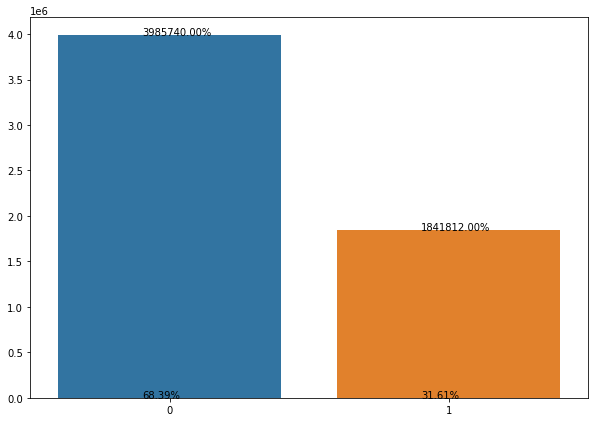

In [13]:
# plot_feature_freq(df, feature, qt_cat)
plot_feature_freq(dados_droped, 'trocou_aparelho')

### Equilibrando classes

In [14]:
dados['dt_ano_stts'] = np.asarray(dados['dt_ano_stts'], dtype = 'int16')
dados['idade'] = np.asarray(dados['idade'], dtype = 'int16')
dados['fl_3g'] = np.asarray(dados['fl_3g'], dtype = 'int8')
dados['fl_4g'] = np.asarray(dados['fl_4g'], dtype = 'int8')
dados['fl_5g'] = np.asarray(dados['fl_5g'], dtype = 'int8')

In [15]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5840759 entries, 0 to 5840758
Data columns (total 31 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   msisdn                   int64  
 1   imsi                     object 
 2   tac                      int64  
 3   dt_inicio                object 
 4   dt_fim                   object 
 5   aging_aparelho           int64  
 6   cat_aparelho             int64  
 7   trocou_aparelho          int64  
 8   fabricante               object 
 9   modelo                   object 
 10  imei                     object 
 11  ranking                  int64  
 12  cpfidentifier            float64
 13  subscriberkey            int64  
 14  customerkey              int64  
 15  customersubtypedesc      object 
 16  subscriberstatuskey      object 
 17  offertechnology          object 
 18  citydesc                 float64
 19  statedesc                object 
 20  subscribermainofferdesc  object 
 21  assigned

In [16]:
dados.columns

Index(['msisdn', 'imsi', 'tac', 'dt_inicio', 'dt_fim', 'aging_aparelho',
       'cat_aparelho', 'trocou_aparelho', 'fabricante', 'modelo', 'imei',
       'ranking', 'cpfidentifier', 'subscriberkey', 'customerkey',
       'customersubtypedesc', 'subscriberstatuskey', 'offertechnology',
       'citydesc', 'statedesc', 'subscribermainofferdesc',
       'assignedchargeamount', 'fl_3g', 'fl_4g', 'fl_5g', 'dt_ano_stts',
       'idade', 'avg_msisdn', 'avg_cpf', 'peso_aparelho', 'update_software'],
      dtype='object')

***
### Analise individual

In [88]:
# dados_droped_ta = dados_droped[dados_droped['trocou_aparelho'] == 0]
# dados_droped_ta.shape

In [89]:
dados_droped['dt_inicio'].min()

'2012-08-22'

In [92]:
dados_droped['dt_fim'].unique()

array([nan, '2022-05-04', '2022-04-14', '2022-05-20', '2022-05-13',
       '2022-04-02', '2022-04-21', '2022-03-26', '2022-05-30',
       '2022-03-09', '2022-05-11', '2022-02-25', '2022-03-07',
       '2022-06-14', '2022-03-16', '2022-02-15', '2022-02-14',
       '2022-05-06', '2022-06-13', '2022-03-13', '2022-02-12',
       '2022-02-09', '2022-05-09', '2022-03-22', '2022-03-10',
       '2022-03-30', '2022-05-14', '2022-02-20', '2022-05-22',
       '2022-04-30', '2022-04-16', '2022-02-08', '2022-06-05',
       '2022-05-16', '2022-06-03', '2022-04-27', '2022-05-05',
       '2022-05-24', '2022-04-09', '2022-05-07', '2022-05-29',
       '2022-03-11', '2022-02-11', '2022-06-02', '2022-05-18',
       '2022-05-02', '2022-03-03', '2022-02-18', '2022-06-17',
       '2022-06-11', '2022-02-24', '2022-04-05', '2022-06-08',
       '2022-03-01', '2022-06-10', '2022-05-23', '2022-04-13',
       '2022-04-01', '2022-06-20', '2022-06-07', '2022-04-12',
       '2022-04-28', '2022-04-23', '2022-04-08', '

In [17]:
dados_droped['trocou_aparelho'].unique()

array([0, 1])

In [95]:
dados_droped['cat_aparelho'].unique()

array([0, 1, 2, 3, 4, 5])

In [94]:
dados_droped['aging_aparelho'].unique()

array([ 10,  23,   7,   4,   0,  14,   9,   6,   8,  15,  27,   5,  11,
        39,  13,  19,  45,  24,  20,  49,  35,  44,  22,  17,  30,  28,
        48,  18,  34,  21,  53,  26,  37,  31,  12,  36,  25,  47,  32,
        62,  33,  16,   3,  42,  40,  51,  80,  41,  50,   2,  29,  43,
        63,  46,  58,  76,  61,  65,  38,   1,  54,  55,  64,  56,  57,
       106,  68,  67,  52,  66,  59,  60,  74,  75,  71,  91,  78, 102,
        77,  69,  81,  92,  82,  79,  84,  72,  83,  70,  93,  89,  85,
        73,  86, 104, 115, 109,  87,  94, 110,  88, 105, 114,  90,  95,
        97,  96, 116, 100, 107,  98, 108, 119, 103, 101, 111,  99, 117,
       118, 112, 120, 113, 121])

In [20]:
dados_droped['customersubtypedesc'].unique()

array(['Pessoa Física', 'Funcionário Vivo'], dtype=object)

In [97]:
dados_droped['fabricante'].unique()

array(['APPLE', 'Apple Inc', 'Techno Group Fzc',
       'Hongkong IPRO Technology Co Limited'], dtype=object)

In [99]:
dados_droped['modelo'].unique()

array(['IPHONE 12 (A2403)', 'IPHONE SE (A2296)', 'IPHONE 11 (A2221)',
       'IPHONE 7 (A1778)', 'IPHONE XR (A2105)',
       'IPHONE 13 PRO MAX (A2643)', 'IPHONE 6S (A1688)',
       'IPHONE 13 PRO MAX (A2484)', 'IPHONE 7 PLUS (A1784)',
       'IPHONE 5S (A1457)', 'IPHONE 8 (A1905)', 'IPHONE4S (A1387)',
       'IPHONE 12 PRO (A2341)', 'IPHONE 12 PRO MAX (A2411)',
       'IPHONE X (A1901)', 'IPHONE 8 (A1906)', 'IPHONE 11 PRO (A2160)',
       'IPHONE 12 PRO MAX (A2342)', 'IPHONE 11 (A2111)',
       'IPHONE 7 (A1660)', 'IPHONE SE (A1723)', 'IPHONE 11 PRO (A2215)',
       'IPHONE 8 PLUS (A1897)', 'IPHONE 11 PRO MAX (A2218)',
       'IPHONE XS (A1920)', 'IPHONE 11 PRO MAX (A2161)',
       'IPHONE XR (A1984)', 'IPHONE 13 (A2633)', 'IPHONE X (A1865)',
       'IPHONE 13 (A2482)', 'IPHONE 12 (A2172)', 'IPHONE 8 (A1863)',
       'IPHONE 13 PRO (A2483)', 'IPHONE 13 PRO (A2638)',
       'IPHONE 7 PLUS (A1661)', 'IPHONE 8 PLUS (A1864)',
       'IPHONE 6 LTE-A (A1549)', 'IPHONE 12 MINI (A2399)',
    

In [21]:
dados_droped['subscriberstatuskey'].unique()

array(['A'], dtype=object)

In [22]:
dados_droped['ranking'].unique()

array([ 1,  2,  3,  5,  6,  4, 11,  7,  9,  8, 10, 12, 13, 15, 14, 16, 17,
       18, 27, 25, 26, 20, 22, 30, 29, 23, 28, 19, 24, 21, 33, 34, 31, 47,
       38, 36, 37, 35, 46, 32, 40, 42, 44, 41, 39, 43, 48, 45])

In [23]:
dados_droped['fl_3g'].equals(dados_droped['fl_4g'])

False

In [24]:
dados_droped['fl_3g'].equals(dados_droped['fl_5g'])

False

In [25]:
dados_droped['fl_4g'].equals(dados_droped['fl_5g'])

False

In [115]:
dados_droped['idade'].describe()

count    5.827552e+06
mean     4.278304e+01
std      1.482878e+01
min     -2.999000e+03
25%      3.100000e+01
50%      4.100000e+01
75%      5.300000e+01
max      2.690000e+02
Name: idade, dtype: float64

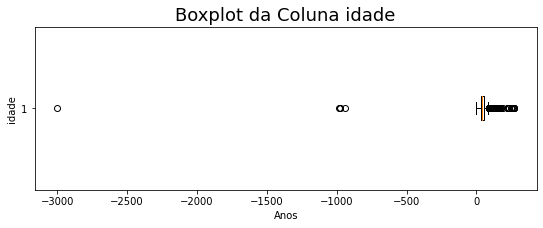

In [100]:
# Tamanho do gráfico em polegadas
plt.figure(figsize =(9, 3))

#Plotando o boxplot das espécies em relação ao tamanho das sépalas
bplots = plt.boxplot(dados_droped['idade'], vert = 0)

# Adicionando Título ao gráfico
plt.title("Boxplot da Coluna idade", loc="center", fontsize=18)
plt.xlabel("Anos")
plt.ylabel("idade")

plt.show()

In [28]:
dados_droped['dt_ano_stts'].describe()

count    5.827552e+06
mean     2.018489e+03
std      1.907407e+00
min      2.007000e+03
25%      2.017000e+03
50%      2.019000e+03
75%      2.020000e+03
max      2.022000e+03
Name: dt_ano_stts, dtype: float64

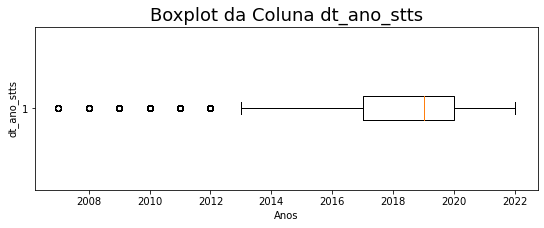

In [29]:
# Tamanho do gráfico em polegadas
plt.figure(figsize =(9, 3))

#Plotando o boxplot das espécies em relação ao tamanho das sépalas
bplots = plt.boxplot(dados_droped['dt_ano_stts'], vert = 0)

# Adicionando Título ao gráfico
plt.title("Boxplot da Coluna dt_ano_stts", loc="center", fontsize=18)
plt.xlabel("Anos")
plt.ylabel("dt_ano_stts")

plt.show()

In [120]:
dados_droped['avg_msisdn'].max()

117.0

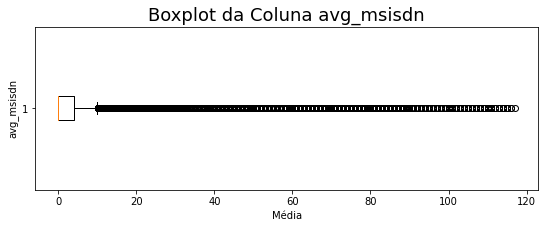

In [31]:
# Tamanho do gráfico em polegadas
plt.figure(figsize =(9, 3))

#Plotando o boxplot das espécies em relação ao tamanho das sépalas
bplots = plt.boxplot(dados_droped['avg_msisdn'], vert = 0)

# Adicionando Título ao gráfico
plt.title("Boxplot da Coluna avg_msisdn", loc="center", fontsize=18)
plt.xlabel("Média")
plt.ylabel("avg_msisdn")

plt.show()

In [126]:
dados_droped['avg_cpf'].describe()

count    5.827552e+06
mean     6.444832e+00
std      1.188968e+01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      8.000000e+00
max      1.160000e+02
Name: avg_cpf, dtype: float64

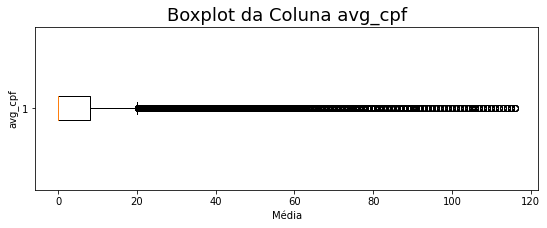

In [33]:
# Tamanho do gráfico em polegadas
plt.figure(figsize =(9, 3))

#Plotando o boxplot das espécies em relação ao tamanho das sépalas
bplots = plt.boxplot(dados_droped['avg_cpf'], vert = 0)

# Adicionando Título ao gráfico
plt.title("Boxplot da Coluna avg_cpf", loc="center", fontsize=18)
plt.xlabel("Média")
plt.ylabel("avg_cpf")

plt.show()

In [34]:
# dados_droped['peso_aparelho'].unique()

In [35]:
# dados_droped['update_software'].unique()

In [111]:
dados_droped['assignedchargeamount'].describe()

count    5.827552e+06
mean     7.709687e+01
std      9.032556e+01
min     -1.367000e+02
25%      3.749000e+01
50%      5.699000e+01
75%      8.699000e+01
max      2.257980e+03
Name: assignedchargeamount, dtype: float64

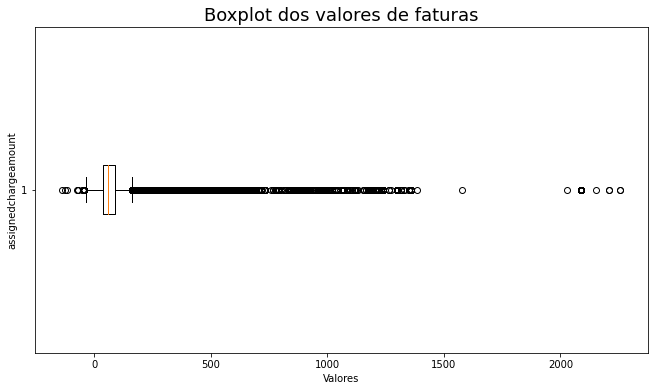

In [37]:
# Tamanho do gráfico em polegadas
plt.figure(figsize =(11, 6))

#Plotando o boxplot das espécies em relação ao tamanho das sépalas
bplots = plt.boxplot(dados_droped['assignedchargeamount'],  vert = 0, patch_artist = False)

# Adicionando Título ao gráfico
plt.title("Boxplot dos valores de faturas", loc="center", fontsize=18)
plt.xlabel("Valores")
plt.ylabel("assignedchargeamount")

plt.show()

In [44]:
dados_droped['peso_aparelho'].unique()

array(['2403', '2296', '2221', '1778', '2105', '2643', '1688', '2484',
       '1784', '1457', '1905', '1387', '2341', '2411', '1901', '1906',
       '2160', '2342', '2111', '1660', '1723', '2215', '1897', '2218',
       '1920', '2161', '1984', '2633', '1865', '2482', '2172', '1863',
       '2483', '2638', '1661', '1864', '1549', '2399', '2101', '1687',
       '2407', '1921', '1633', '2641', '2102', '1586', '1522', '2097',
       '1662', '1524', '2406', 'IPHONE4', '1902', '1898', '2106', '2098',
       '2783', '1634', '2628', '1779', '1507', '2636', '2107', '2631',
       '1533', '2481', '2402', '1785', '1428', '1532', '2595', '2176',
       '2108', '1429', '2223', '1699', '1899', '2275', '2410', '2398',
       '1453', '2404', '2100', '1530', '1780', '2626', '2104', '1907',
       '2220', '2412', '1303', '2644', '2217', '2408', '2634', '1528',
       '2635', '1700', 'IPHONE3G', '2639', '1589', '1456', '1529', '1431',
       '1593', '1518', '2400', 'IPHONE', '1786', 'IPHONE3GS', '2645',


In [39]:
dados_droped['update_software'].unique()

array([1, 0])

***
## Data Analysis

In [40]:
# from pandas_profiling import ProfileReport

In [41]:
# dados_analysis = ProfileReport(dados_droped, title="Profiling Report", progress_bar=True, infer_dtypes=False)
# profile_td_html = dados_analysis.to_html()

In [42]:
# display(HTML(profile_td_html))